<a href="https://colab.research.google.com/github/PeterPirog/tensorflow-deep-learning/blob/workspace/03_cnn_multi_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://poloclub.github.io/cnn-explainer/

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2021-12-31 20:31:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   191MB/s    in 0.5s    

2021-12-31 20:31:50 (191 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'pizza_steak'
There are 2 directories and 0 images in 'pizza_steak/train'
There are 0 directories and 750 images in 'pizza_steak/train/steak'
There are 0 directories and 750 images in 'pizza_steak/train/pizza'
There are 2 directories and 0 images in 'pizza_steak/test'
There are 0 directories and 250 images in 'pizza_steak/test/steak'
There are 0 directories and 250 images in 'pizza_steak/test/pizza'


In [4]:
num_steak_images_train=len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [5]:
#Visualization
# Get the class names programatically
import pathlib
import numpy as np
data_dir=pathlib.Path("pizza_steak/train")
#Create list of class names from subdirectories
class_names=np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['pizza' 'steak']


In [6]:
# visualize images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class

  #Get random image
  random_image=random.sample(os.listdir(target_folder),1)

  img=mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")
  return img


Image shape: (512, 512, 3)


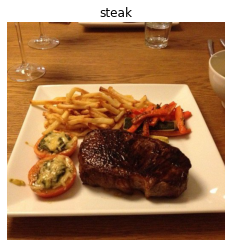

In [7]:
img=view_random_image(target_dir="pizza_steak/train/",target_class="steak")

Image shape: (512, 512, 3)


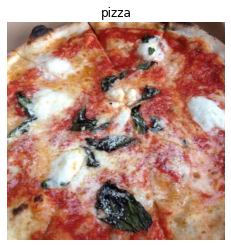

In [8]:
img=view_random_image(target_dir="pizza_steak/train/",target_class="pizza")

In [9]:
import tensorflow as tf
tf.constant(img,dtype=tf.float32)

<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
array([[[185., 167., 157.],
        [184., 166., 156.],
        [183., 165., 155.],
        ...,
        [132., 122., 120.],
        [134., 126., 123.],
        [133., 128., 125.]],

       [[185., 167., 157.],
        [184., 166., 156.],
        [184., 166., 156.],
        ...,
        [129., 119., 117.],
        [132., 124., 121.],
        [132., 127., 124.]],

       [[184., 166., 156.],
        [184., 166., 156.],
        [184., 166., 156.],
        ...,
        [123., 112., 108.],
        [127., 119., 116.],
        [131., 123., 120.]],

       ...,

       [[223., 203., 166.],
        [222., 204., 168.],
        [224., 208., 174.],
        ...,
        [129.,  81.,  45.],
        [125.,  77.,  41.],
        [121.,  73.,  37.]],

       [[223., 203., 166.],
        [223., 205., 167.],
        [225., 209., 173.],
        ...,
        [138.,  90.,  50.],
        [132.,  83.,  43.],
        [120.,  71.,  31.]],

       [[221., 20

In [10]:
# Build CNN network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

conv_base=Xception(weights='imagenet',
                   include_top=False,
                   input_shape=(299,299,3))
conv_base.trainable=False #freeze weights to not train

# set seed
tf.random.set_seed(42)

#Image proprocessing
train_datagen =ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

valid_datagen =ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# Setup paths for data directories
train_dir="pizza_steak/train"
test_dir="pizza_steak/test"

# Import data from directories
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(299,299),
                                               class_mode="binary",
                                               seed=42,
                                               shuffle=False)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(299,299),
                                               class_mode="binary",
                                               seed=42,
                                               shuffle=False)

83697664/83683744 [==============================] - 2s 0us/step
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [11]:
model=tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 1)                 204801    
                                                                 
Total params: 21,066,281
Trainable params: 204,801
Non-trainable params: 20,861,480
_________________________________________________________________


In [12]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # 7.0795e-04
              metrics=["accuracy"])

In [13]:
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', #val_loss
                                                factor=0.5,
                                                patience=3,
                                                min_lr=1e-5),
           tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=5),
           tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5',
                                              monitor='val_accuracy',
                                              save_best_only=True)]

In [14]:
history=model.fit(train_data,
          epochs=100,
          steps_per_epoch=len(train_data), # len(train_data) - number of batches
          validation_data=valid_data,
          validation_steps=len(valid_data),
          callbacks=callbacks) 

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 1.5059 - accuracy: 0.8800

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


47/47 [==============================] - 86s 2s/step - loss: 1.5059 - accuracy: 0.8800 - val_loss: 0.2452 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 65s 1s/step - loss: 0.3784 - accuracy: 0.9547 - val_loss: 0.1036 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 64s 1s/step - loss: 0.1906 - accuracy: 0.9687 - val_loss: 0.0991 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 63s 1s/step - loss: 0.1210 - accuracy: 0.9800 - val_loss: 0.1013 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 63s 1s/step - loss: 0.1508 - accuracy: 0.9767 - val_loss: 0.0529 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 63s 1s/step - loss: 0.1447 - accuracy: 0.9773 - val_loss: 0.1517 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 63s 1s/step - loss: 0.0636 - accura

In [15]:
print(history.history.keys())
#pd.DataFrame(history.history).plot()
#plt.ylabel("loss")
#plt.xlabel("epochs")
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


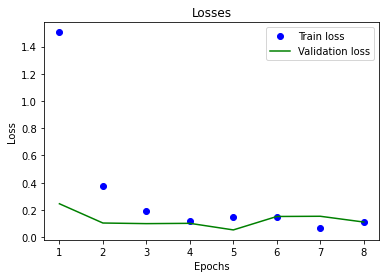

In [16]:
plt.plot(epochs,loss,'bo',label='Train loss')
plt.plot(epochs,val_loss,'g',label='Validation loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

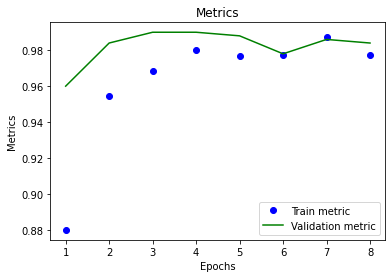

In [17]:
plt.plot(epochs,acc,'bo',label='Train metric')
plt.plot(epochs,val_acc,'g',label='Validation metric')
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend();

--2021-12-31 20:47:13--  https://st.depositphotos.com/1020804/1448/i/950/depositphotos_14480443-stock-photo-beef-steak.jpg
Resolving st.depositphotos.com (st.depositphotos.com)... 23.202.211.110
Connecting to st.depositphotos.com (st.depositphotos.com)|23.202.211.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204217 (199K) [image/jpeg]
Saving to: ‘depositphotos_14480443-stock-photo-beef-steak.jpg.2’

depositphotos_14480 100%[===================>] 199.43K  --.-KB/s    in 0.04s   

2021-12-31 20:47:13 (5.32 MB/s) - ‘depositphotos_14480443-stock-photo-beef-steak.jpg.2’ saved [204217/204217]



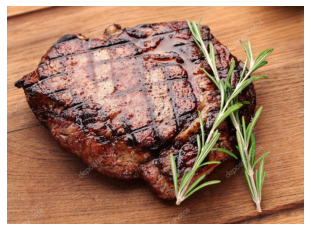

In [20]:
import matplotlib.image as mpimg
!wget https://st.depositphotos.com/1020804/1448/i/950/depositphotos_14480443-stock-photo-beef-steak.jpg
steak=mpimg.imread("depositphotos_14480443-stock-photo-beef-steak.jpg")
plt.imshow(steak)
plt.axis(False);

In [30]:
img=tf.io.read_file(filename="depositphotos_14480443-stock-photo-beef-steak.jpg")
img=tf.image.decode_image(img)
img=tf.image.resize(img,size=[299,299])
img=img/255.
img.shape
model.predict(tf.expand_dims(img,axis=0))

array([[0.9998919]], dtype=float32)